# Analyzing university data using self-organizing maps and MLPs

In this project we'll take a look at the data from the top ranking universities in the world. We'll use two datasets from the *World University Rankings* Kaggle competition. After preprocessing and cleaning the data, we'll feed it to a self-organizing map to see how these universities are clustered; we'll be able to see the things they have in common and where they differ. Finally, we'll take on the task of predicting certain aspects.

[![png](images/kaggle-img.png)](https://www.kaggle.com/mylesoneill/world-university-rankings)

## Packages

For this project we'll use numpy and pandas to preprocess the data, matplotlib and seaborn to visualize it, and tensorflow to create the MLP model:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras

## Data

We'll use two datasets from the competition:
- Data from the Center from World University Rankings (CWUR)
- Data from the Times Higher Education World University Rankings

These two datasets will allow us to create a bigger, richer set of data by merging them together.

In [2]:
cwur_data = pd.read_csv('world-university-rankings/cwurData.csv')
times_data = pd.read_csv('world-university-rankings/timesData.csv')

## Preprocessing

Before merging the two datasets together we have to do a fair ammount of preprocessing. Inspecting just the head of both gives us key information about the tasks we'll have to go through:
- Handle NaN values
- Keep only the most recent data and iscard duplicates from past years
- Parse and format columns like *num_students, international_students* and *female_male_ratio*
- etc

In [3]:
display(cwur_data.head())

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


In [4]:
display(times_data.head())

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011


To keep things simple, we'll rename the Time's column to institution, so it's consistent with the CWUR's dataset:

In [ ]:
times_data.rename(columns={'university_name': 'institution'}, inplace=True)

##### Keeping the most recent data

We can see how both datasets have data from several and different years. To prevent redundancy, we'll keep only the most recent ones:

In [6]:
cwur_data['year'].value_counts()

2015    1000
2014    1000
2013     100
2012     100
Name: year, dtype: int64

In [7]:
times_data['year'].value_counts()

2016    800
2012    402
2015    401
2013    400
2014    400
2011    200
Name: year, dtype: int64

In order to do that, we'll sort the dataset in a descending manner and drop the duplicates based on the *institution column*, keeping the first occurrence:

In [8]:
cwur_data.sort_values(by=['year'], ascending=False, inplace=True)
cwur_data.drop_duplicates(subset=['institution'], keep='first', inplace=True)
times_data.sort_values(by=['year'], ascending=False, inplace=True)
times_data.drop_duplicates(subset=['institution'], keep='first', inplace=True)

We've trimmed a large part of the dataset in the process:

In [9]:
cwur_data['year'].value_counts()

2015    1000
2014      23
2012       1
Name: year, dtype: int64

In [10]:
times_data['year'].value_counts()

2016    800
2015      8
2014      3
2013      3
2012      3
2011      1
Name: year, dtype: int64

##### Dropping conflicting columns

We'll now get rid of redundant and conflictive columns; those that provide similar information, like the year, country and world rank:

In [11]:
cwur_data.drop(columns=['country', 'year'], inplace=True)
times_data.drop(columns=['world_rank'], inplace=True)

Once those columns have been drop we can proceed and join both datasets:

In [12]:
data = times_data.set_index('institution').join(cwur_data.set_index('institution'), on='institution', rsuffix='_cwur')

The only "duplicate" column that we've kept for now is the *citations* one. Even though the naming may be confusing, the *citations* column refers, according to kaggle, to *"number of students at the university"*. We'll drop the one with the highest ammount of NaN values:

In [13]:
data['citations'].isna().sum()

0

In [14]:
data['citations_cwur'].isna().sum()

229

In [15]:
data.drop(columns=['citations_cwur'], inplace=True)

### Analizing column values

Now that we have joined the data in a single dataset, it's necessary to check if it has an appropiate structure. We'll have to check for NaN values and values that are not in the expected format.

Inspecting the head of the dataset we can see multiple NaN and unexpected values in several columns, such as '-' or '%', plus a strange way to signify the female to male ratio. We'll go column by column fixing the inadequacies:

In [16]:
data[data.columns[:10]].head()

,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students
institution,,,,,,,,,,
Yuan Ze University,Taiwan,16.2,17.7,18.3,28.6,39.8,-,"8,663",20.6,4%
University of Delaware,United States of America,23.7,41.6,34.0,70.0,98.7,-,"19,262",15.9,10%
Koç University,Turkey,21.2,53.5,27.1,74.9,82.4,-,"4,488",14.6,8%
King Abdulaziz University,Saudi Arabia,23.9,93.0,11.8,76.6,73.1,-,"35,889",8.4,21%
Justus Liebig University Giessen,Germany,32.9,46.8,33.9,52.9,46.4,-,"25,682",53.9,9%


In [17]:
data[data.columns[10:]].head()

,female_male_ratio,year,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,broad_impact,patents,score
institution,,,,,,,,,,,,
Yuan Ze University,43 : 57,2016,979.0,20.0,367.0,567.0,218.0,923.0,984.0,946.0,871.0,44.05
University of Delaware,56 : 44,2016,281.0,109.0,318.0,337.0,135.0,272.0,304.0,292.0,120.0,46.21
Koç University,52 : 48,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
King Abdulaziz University,57 : 43,2016,995.0,4.0,367.0,449.0,218.0,595.0,430.0,994.0,839.0,44.03
Justus Liebig University Giessen,62 : 38,2016,358.0,32.0,367.0,567.0,218.0,332.0,357.0,313.0,309.0,45.43


In [ ]:
data.dtypes

### *num_students*

In this column the comma is used to denote the thousand mark. We'll delete the comma, convert the column to int and fill the NaN values with the column average, as there aren't many NaN values to begin with:

In [18]:
cleaned = data.loc[data.num_students.notna(), 'num_students'].str.replace(',', '').astype('int32')
data.loc[data.num_students.notna(), 'num_students'] = cleaned
data.loc[data.num_students.isna(), 'num_students'] = cleaned.mean()
data.num_students = data.num_students.astype('int32')

###  *student_staff_ratio*

In a similar fashion, we'll substitute the NaN values for the column's average:

In [19]:
data.loc[data.student_staff_ratio.isna(), 'student_staff_ratio'] = data.student_staff_ratio.mean()

### *international_students*

Here we'll have to delete the '%' sign and fill some NaN values:

In [20]:
cleaned = data.loc[data.international_students.notna(), 'international_students'].str.replace('%', '').astype('int32')
data.loc[data.international_students.notna(), 'international_students'] = cleaned
data.loc[data.international_students.isna(), 'international_students'] = cleaned.mean()
data.international_students = data.international_students.astype('float64')

### *female_male_ratio*

Here's one of the trickiest problems in the dataset: the female to male ratio is written as *female percentage : male percentage"*. In order to calculate the ratio in a useful way we'll need to wrestle with the data:

In [21]:
f2m = data.female_male_ratio

In [22]:
separated = f2m[f2m.notna()].str.partition(':')

After running that we'll be left with 3 columns: one for the female percentage, one for the separator and one for the male percentage:

In [23]:
separated.head()

,0,1,2
institution,,,
Yuan Ze University,43,:,57
University of Delaware,56,:,44
Koç University,52,:,48
King Abdulaziz University,57,:,43
Justus Liebig University Giessen,62,:,38


Now we have to clean the data, as this column use the character '-' for missing data:

In [24]:
female = separated[0]

In [25]:
female = female.str.rstrip()

In [26]:
female.unique()

array(['43', '56', '52', '57', '62', '63', '44', '19', '66', '50', '26',
       '67', '58', '46', '61', '32', '54', '60', '39', '55', '48', '30',
       '31', '47', '33', '51', '53', '49', '13', '25', '28', '59', '71',
       '77', '34', '40', '65', '27', '42', '38', '16', '22', '64', '69',
       '29', '41', '35', '37', '45', '70', '20', '18', '36', '21', '11',
       '78', '17', '-', '9', '74', '1', '68', '12', '23', '100', '24',
       '15', '76', '14'], dtype=object)

In [27]:
female.loc[female == '-'] = np.NaN

We end up with 3 NaN values:

In [28]:
female.loc[female.isna()]

institution
AGH University of Science and Technology          NaN
Czech Technical University in Prague              NaN
King Fahd University of Petroleum and Minerals    NaN
Name: 0, dtype: object

In [29]:
male = separated[2]

We'll do a similar thing with the male percentage column:

In [30]:
male.unique()

array([' 57', ' 44', ' 48', ' 43', ' 38', ' 37', ' 56', ' 81', ' 34',
       ' 50', ' 74', ' 33', ' 42', ' 54', ' 39', ' 68', ' 46', ' 40',
       ' 61', ' 45', ' 52', ' 70', ' 69', ' 53', ' 67', ' 49', ' 47',
       ' 51', ' 87', ' 75', ' 72', ' 41', ' 29', ' 23', ' 66', ' 60',
       ' 35', ' 73', ' 58', ' 62', ' 84', ' 78', ' 36', ' 31', ' 71',
       ' 59', ' 65', ' 63', ' 55', ' 30', ' 80', ' 82', ' 64', ' 79',
       ' 89', ' 22', ' 83', '', ' 91', ' 26', ' 99', ' 32', ' 88', ' 77',
       ' 0', ' 76', ' 85', ' 24', ' 86'], dtype=object)

In [31]:
male.loc[male == ''] = np.NaN

In [32]:
male.loc[male.isna()]

institution
AGH University of Science and Technology          NaN
Czech Technical University in Prague              NaN
King Fahd University of Petroleum and Minerals    NaN
Name: 2, dtype: object

Now we'll cast these columns to int and fill the 3 missing values with the mean:

In [33]:
female.loc[female.notna()] = female.loc[female.notna()].astype('int32')
male.loc[male.notna()] = male.loc[male.notna()].astype('int32')

female.loc[female.isna()] = female.loc[female.notna()].mean()
male.loc[male.isna()] = male.loc[male.notna()].mean()

In order to get the final female to male ratio we'll have to the former with the latter. In order to prevent errors, we'll substitute any values equal to 0 with 1:

In [33]:
male.loc[male == 0] = 1
ratio = female / male

data.female_male_ratio = ratio

In [34]:
data.female_male_ratio = data.female_male_ratio.astype('float64')

In [35]:
data.loc[data.female_male_ratio.isna(), 'female_male_ratio'] = data.loc[data.female_male_ratio.notna(), 'female_male_ratio'].mean()

### *international* 

Object to float:

In [36]:
data.international = data.international.astype('float32')

### *income*

Substituting '-' with NaN and filling the gaps:

In [37]:
data.loc[data.income == '-', 'income'] = np.NaN
data.loc[data.income.notna(), 'income'] = data.loc[data.income.notna(), 'income'].astype('float32')
data.loc[data.income.isna(), 'income'] = data.loc[data.income.notna(), 'income'].mean()
data.income = data.income.astype('float64')

### *total_score*

We'll drop this column, as it's missing most of its values:

In [38]:
(data.total_score == '-').sum()

616

In [39]:
data.drop(columns=['total_score'], inplace=True)

Now that we are done preprocessing these columns, you can see how all of them have their corresponding type, wheter it's int or float:

In [40]:
data.dtypes

country                    object
teaching                  float64
international             float32
research                  float64
citations                 float64
income                    float64
num_students                int32
student_staff_ratio       float64
international_students    float64
female_male_ratio         float64
year                        int64
world_rank                float64
national_rank             float64
quality_of_education      float64
alumni_employment         float64
quality_of_faculty        float64
publications              float64
influence                 float64
broad_impact              float64
patents                   float64
score                     float64
dtype: object

We can see how a lot of values from the columns *world_rank* and forward are missing. It's a good change to grab these columns and use them as a test set:

In [41]:
data.isna().sum()

country                     0
teaching                    0
international               0
research                    0
citations                   0
income                      0
num_students                0
student_staff_ratio         0
international_students      0
female_male_ratio           0
year                        0
world_rank                229
national_rank             229
quality_of_education      229
alumni_employment         229
quality_of_faculty        229
publications              229
influence                 229
broad_impact              229
patents                   229
score                     229
dtype: int64

In [42]:
data.drop(columns='year', inplace=True)

In [43]:
training_set = data.drop(columns=['country'])

### Outliers

Analizamos el dataset en busca de outliers:

In [44]:
training_set.describe()

,teaching,international,research,citations,income,num_students,student_staff_ratio,international_students,female_male_ratio,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,broad_impact,patents,score
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,31.647677,48.240955,27.988753,51.431663,46.892894,24143.836186,19.080528,12.687264,1.214007,419.470289,30.587436,281.920204,365.536503,189.207131,412.848896,436.334465,423.106961,445.887946,47.789711
std,14.923140,23.587309,19.438262,26.821333,20.035906,22262.395670,12.344627,10.509915,3.487403,271.065518,44.556559,116.858345,194.323125,58.695263,267.129283,280.683081,272.116916,277.413450,7.888502
min,9.900000,7.100000,2.900000,1.200000,27.400000,462.000000,0.600000,0.000000,0.010101,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,44.020000
25%,21.100000,29.349999,14.225000,27.850000,31.900000,12482.500000,12.425000,5.000000,0.851852,192.000000,5.000000,197.000000,194.000000,210.000000,183.000000,192.000000,197.000000,205.000000,44.480000
50%,27.100000,45.200001,22.050000,51.000000,40.000000,20582.000000,16.900000,10.000000,1.127660,387.000000,13.000000,367.000000,413.000000,218.000000,386.000000,398.000000,388.000000,425.000000,45.220000
75%,37.775000,64.775002,35.300000,74.575000,53.550000,29496.500000,22.175000,18.000000,1.272727,621.000000,36.000000,367.000000,567.000000,218.000000,604.000000,657.000000,622.000000,695.000000,47.600000
max,95.600000,99.900002,99.000000,100.000000,100.000000,379231.000000,162.600000,82.000000,100.000000,999.000000,228.000000,367.000000,567.000000,218.000000,997.000000,991.000000,1000.000000,871.000000,100.000000


Eliminamos el outlier en *female_male_ratio*:

In [45]:
training_set = training_set[training_set.female_male_ratio != 100]

### Normalization

Antes de realizar la división es preciso normalizar. Se hará una normalización min max por columnas, esto normalizará los datos entre 0 y 1:

*(valor - min(columna)) / (max(columna) - min(columna)*

In [46]:
# pandas hace esta operación por columnas; no toma el mínimo y el máximo de todo el dataset
training_set = (training_set - training_set.min()) / (training_set.max() - training_set.min())

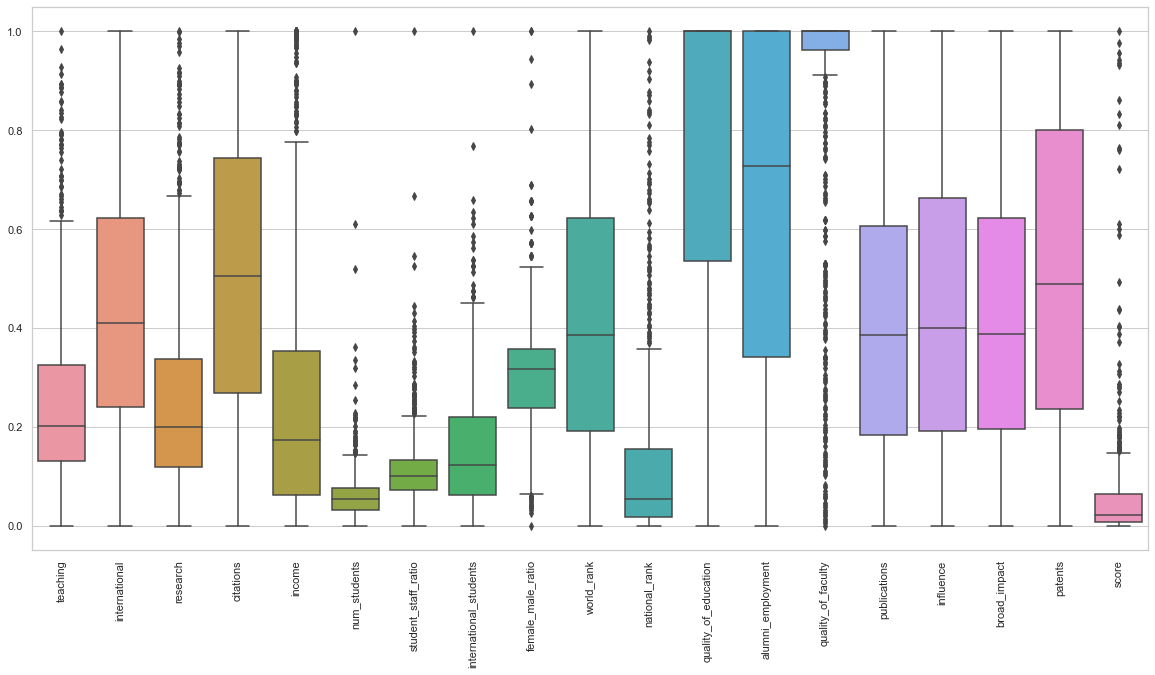

In [47]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, figsize=(20, 10))
ax = sns.boxplot(data=training_set)
plt.xticks(rotation=90)
plt.show()

In [48]:
train = training_set.loc[training_set.world_rank.notna(), :]
test = training_set.loc[training_set.world_rank.isna(), :]

## Self-organizing map

Se diseña un SOM para realizar un clustering de las universidades:

In [49]:
class SOM:
    def __init__(self, input_size, side):
        self.input_size = input_size
        self.side = side
        self.weights = np.random.normal(size=(side, side, input_size))
        self.index_matrix = np.array([np.array([x, y]) for x in range(side) for y in range(side)])\
            .reshape((side, side, 2))
    
    def __call__(self, pattern):
        return self.find_bmu(pattern)
                
    def find_bmu(self, pattern):
        distances = np.sum((self.weights - pattern)**2, axis=2)
        bmu_idx = np.array(np.where(distances == distances.min())).ravel()
        return bmu_idx

    def lr_update(self, initial_lr, i, epochs):
        return initial_lr - (initial_lr / epochs) * i

    def nb_update(self, initial_nb, i, epochs):
        return initial_nb - (initial_nb / epochs) * i

    def lr_decay(self, distance, nb_i):
        return np.exp(-distance / (2 * nb_i**2))
    
    def quantization_error(self, samples):
        error = []
        for sample in samples:
            distances = np.sqrt(np.sum((self.weights - sample)**2, axis=2))
            x, y = np.where(distances == distances.min())
            error.append(distances[x, y])
        return np.mean(error)
    
    def activations(self, samples, plot=False):
        activations = np.zeros((self.side, self.side))
        for sample in samples:
            x, y = self.find_bmu(sample)
            activations[x, y] += 1
        if plot:
            fig, ax = plt.subplots(1, figsize=(11, 10))
            pcm = ax.pcolormesh(activations, cmap='inferno')
            fig.colorbar(pcm, ax=ax)
        return activations

    def fit(self, dataset, epochs, initial_lr, initial_nb, update=10):
        for i in range(epochs):
            order = np.random.choice(len(dataset), len(dataset), replace=False)
            for index in order:
                bmu_idx = self.find_bmu(dataset[index])

                lr_i = self.lr_update(initial_lr, i, epochs)
                nb_i = self.nb_update(initial_nb, i, epochs)

                distances = np.sqrt(np.sum((self.index_matrix - bmu_idx)**2, axis=2))
                decay = self.lr_decay(distances, nb_i)
                affected = distances <= nb_i

                self.weights[affected] += lr_i * np.expand_dims(decay[affected], axis=1)\
                                * (dataset[index] - self.weights[affected])
            if i % update == 0 or i == epochs - 1:
                print(f'Epoch: {i}  Q.E: {self.quantization_error(dataset)}')

### Entrenamiento

In [50]:
som = SOM(input_size=train.shape[-1], side=12)
som.fit(train.to_numpy(), epochs=1000, initial_lr=1, initial_nb=10, update=100)

Época 0  EQ = 0.9788733655466354
Época 100  EQ = 0.9397674843689001
Época 200  EQ = 0.8054699611348856
Época 300  EQ = 0.7426276839958919
Época 400  EQ = 0.7551693839919976
Época 500  EQ = 0.6660404408658379
Época 600  EQ = 0.6167884133367617
Época 700  EQ = 0.5702293773905419
Época 800  EQ = 0.4878626185871154
Época 900  EQ = 0.40126441030099114
Época 999  EQ = 0.3287666019541033


### Pruebas

Se crea un nuevo dataset que incluya la información del país y tenga los datos normalizados:

In [51]:
data_normalized = data.copy(deep=True)
data_normalized[train.columns] = train[train.columns]
data_normalized.dropna(axis=0, inplace=True)
data_normalized.head()

,country,teaching,international,research,citations,income,num_students,student_staff_ratio,international_students,female_male_ratio,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,broad_impact,patents,score
institution,,,,,,,,,,,,,,,,,,,,
Yuan Ze University,Taiwan,0.073512,0.114224,0.160250,0.277328,0.170799,0.021652,0.123457,0.048780,0.210526,0.979960,0.083700,1.00000,1.000000,1.000000,0.925703,0.992929,0.945946,1.000000,0.000536
University of Delaware,United States of America,0.161027,0.371767,0.323621,0.696356,0.982094,0.049634,0.094444,0.121951,0.357143,0.280561,0.475771,0.86612,0.593640,0.617512,0.272088,0.306061,0.291291,0.136782,0.039121
King Abdulaziz University,Saudi Arabia,0.163361,0.925647,0.092612,0.763158,0.629477,0.093532,0.048148,0.256098,0.372093,0.995992,0.013216,1.00000,0.791519,1.000000,0.596386,0.433333,0.993994,0.963218,0.000179
Justus Liebig University Giessen,Germany,0.268378,0.427802,0.322581,0.523279,0.261708,0.066584,0.329012,0.109756,0.458647,0.357715,0.136564,1.00000,1.000000,1.000000,0.332329,0.359596,0.312312,0.354023,0.025188
James Cook University,Australia,0.106184,0.682112,0.207076,0.811741,0.183196,0.029704,0.131481,0.134146,0.478764,0.541082,0.052863,1.00000,1.000000,1.000000,0.506024,0.249495,0.456456,0.763218,0.011611


Se investigará como el SOM clasifica diferentes subconjuntos:

#### Conjunto de entrenamiento en general

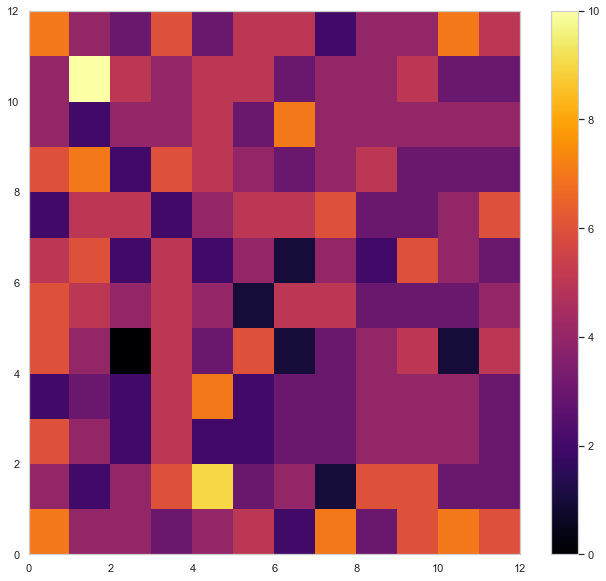

In [52]:
activations = som.activations(train.to_numpy(), plot=True)

### Top 50 de universidades

##### Relación entre el rango global, la calidad de la educación, la calidad de la facultad y la empleabilidad de los alumnos:

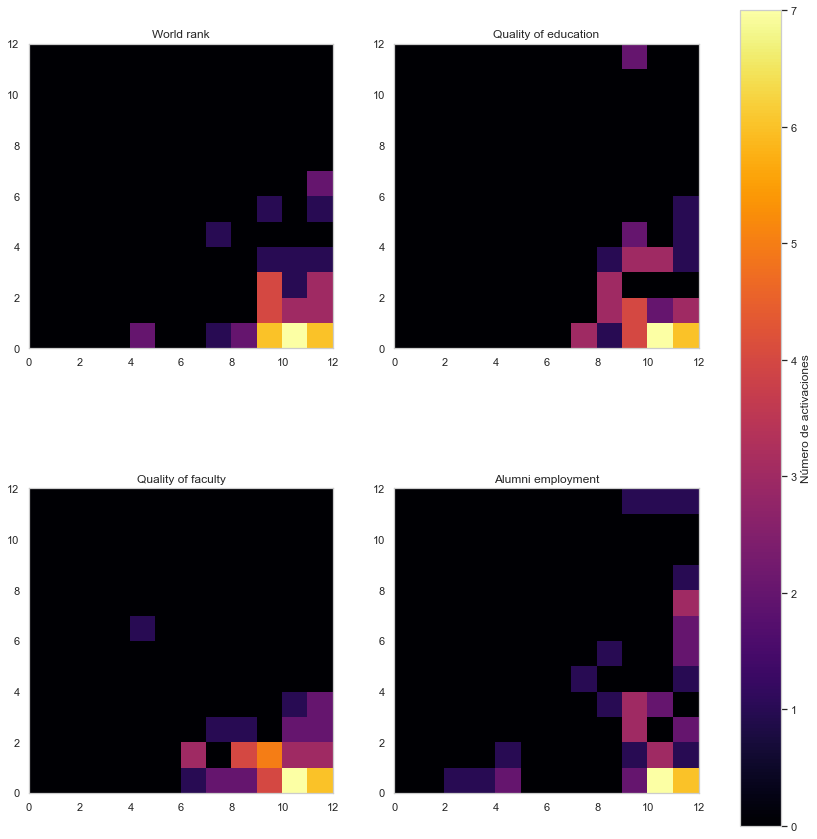

In [53]:
values = ['world_rank', 'quality_of_education', 'quality_of_faculty', 'alumni_employment']
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for value, ax in zip(values, axs.flat):
    subset = data_normalized.sort_values(by=value).iloc[:50, 1:].to_numpy()
    activations = som.activations(subset)
    pcm = ax.pcolormesh(activations, cmap='inferno')
    ax.set_title(value.capitalize().replace('_', ' '))
    ax.set_aspect('equal')

fig.colorbar(pcm, ax=axs, label='Número de activaciones', orientation='vertical')
plt.show()

Hay una clara correlación entre las universidades bien calificadas, con buena calidad de educación y facultad, y la tasa de empleabilidad de sus alumnos.

##### Publicaciones, volumen de investigación, calidad de enseñanza

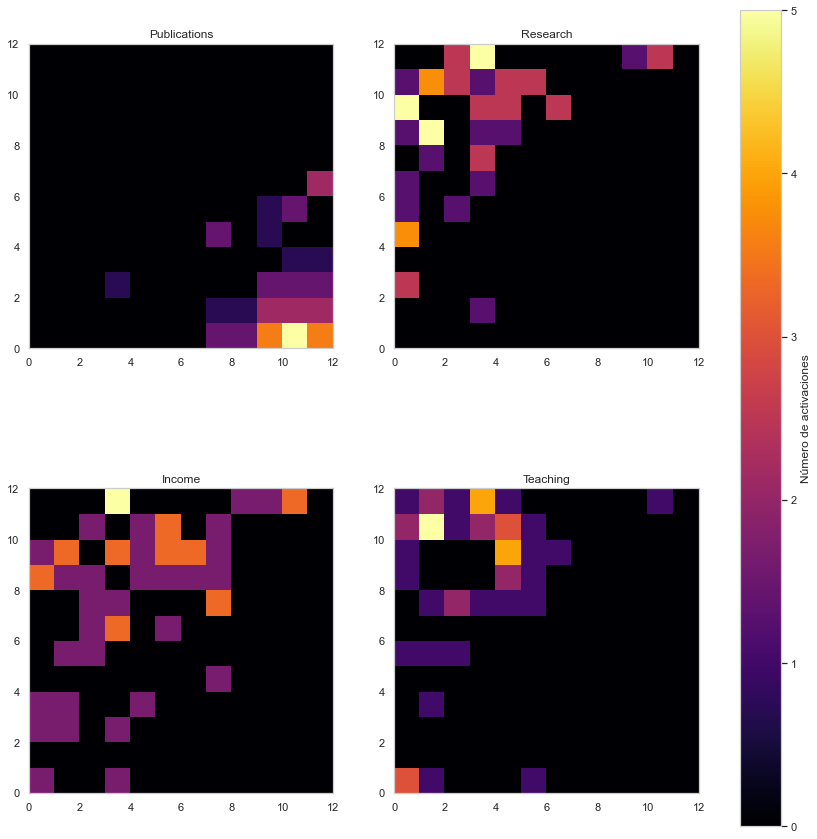

In [54]:
values = ['publications', 'research', 'income', 'teaching']
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for value, ax in zip(values, axs.flat):
    subset = data_normalized.sort_values(by=value).iloc[:50, 1:].to_numpy()
    activations = som.activations(subset)
    pcm = ax.pcolormesh(activations, cmap='inferno')
    ax.set_title(value.capitalize().replace('_', ' '))
    ax.set_aspect('equal')

fig.colorbar(pcm, ax=axs, label='Número de activaciones', orientation='vertical')
plt.show()

#### Países en el top 50 mundial vs top 50 de ratio mujeres/hombres

In [55]:
values = list(data_normalized.sort_values(by='world_rank').iloc[:50, :]['country'].unique())
values.pop(-1)
values.extend(['influence', 'female_male_ratio'])

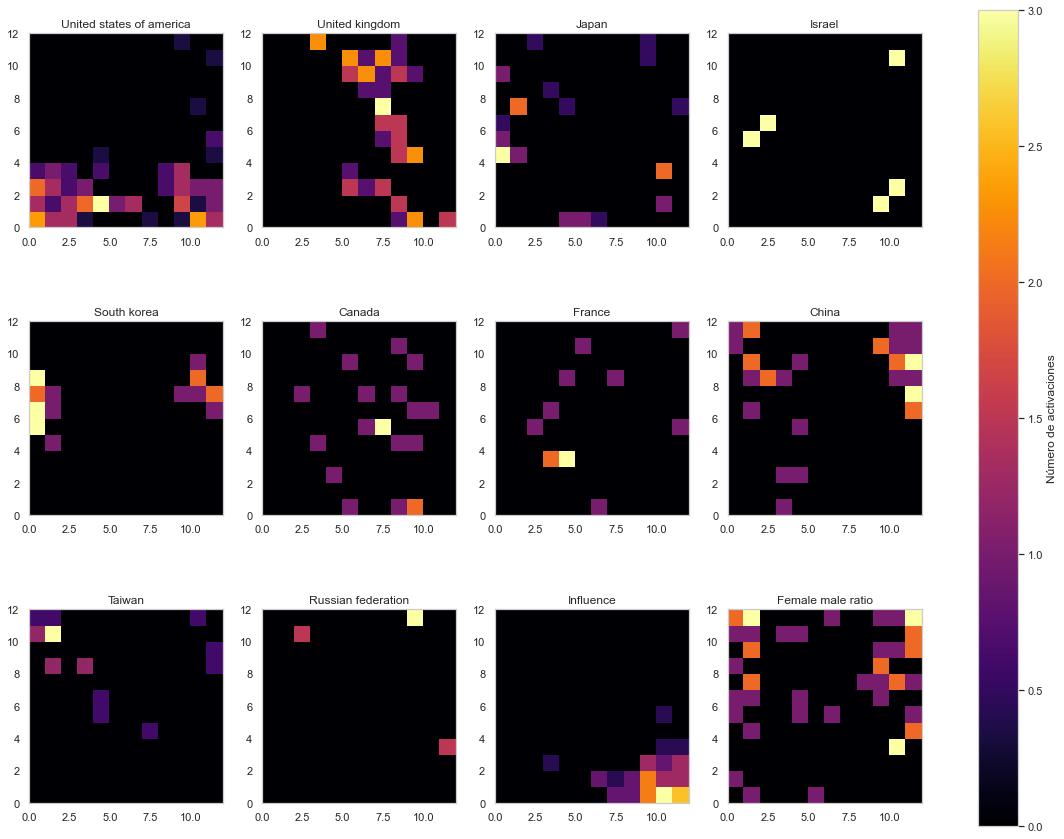

In [56]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

top50fm = data_normalized.sort_values(by='female_male_ratio').iloc[:50, 1:].to_numpy()

for i, (value, ax) in enumerate(zip(values, axs.flat)):
    
    if i == len(values) - 1:
        subset = data_normalized.sort_values(by=value).iloc[:50, 1:].to_numpy()
    elif i == len(values) - 2:
        subset = data_normalized.sort_values(by=value).iloc[:50, 1:].to_numpy()
    else:
        subset = data_normalized.loc[data_normalized.country == value, :].iloc[:, 1:].to_numpy()
        
    activations = som.activations(subset)
    pcm = ax.pcolormesh(activations, cmap='inferno')
    ax.set_title(value.capitalize().replace('_', ' '))
    ax.set_aspect('equal')

fig.colorbar(pcm, ax=axs, label='Número de activaciones', orientation='vertical')
plt.show()

# Clasificación mediante MLP

El dataset se dividirá en dos categorías: universidades dentro y fuera del top 500. Se emplearán los otros valores para predecir la pertenencia. Se empleará un perceptrón multicapa con salida binaria, denotando 1 la pertenencia al top 500 y 0 la ausencia.

### Preprocesamiento

El preprocesamiento a realizar es mínimo. Tan solo hay que asignar las etiquetas y eliminar las columnas de *world_rank* y *score* (esta segunda empleada para determinar la primera). Se seleccionará el TOP 5 y el TOP -5 para pruebas posteriores:

##### Conjunto de entrenamiento

In [57]:
minus_top = train.sort_values(by='world_rank').iloc[5:-5, :]
x = minus_top.drop(columns=['world_rank', 'score']).to_numpy()

Y asignar a aquellos que estén por encima de la media un 1, y a los demás un 0:

In [58]:
y = np.where(minus_top.world_rank.values > minus_top.world_rank.mean(), 0, 1)

##### Conjunto de test

In [59]:
top_5 = train.sort_values(by='world_rank').iloc[:5, :]
bottom_5 = train.sort_values(by='world_rank').iloc[-5:, :]

concat = pd.concat([top_5, bottom_5])
x_test = concat.drop(columns=['world_rank', 'score']).to_numpy()

y_test = np.where(concat.world_rank.values > minus_top.world_rank.mean(), 0, 1)

##### Función de histograma

In [60]:
def plot_history(hist):
    metrics = ['loss', 'accuracy']
    fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
    for metric, ax in zip(metrics, axs.flat):
        ax.plot(hist.history[metric])
        ax.plot(hist.history[f'val_{metric}'])
        ax.set_title(f'Model {metric}')
        ax.set_ylabel(metric.capitalize())
        ax.legend(['Train', 'Validation'], loc='upper left')
    plt.xlabel('Epochs')
    plt.show()

### Modelo

In [74]:
model = keras.Sequential([
    keras.layers.Dense(30, input_shape=(x.shape[-1],), activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
], name='MLP')
model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 30)                540       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [75]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1, restore_best_weights=True)

In [76]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics='accuracy')

In [77]:
hist = model.fit(x, y, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6676 - accuracy: 0.6299 - val_loss: 0.7212 - val_accuracy: 0.3017
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.6688 - val_loss: 0.8032 - val_accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5373 - accuracy: 0.6732 - val_loss: 0.6992 - val_accuracy: 0.6034
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4851 - accuracy: 0.7403 - val_loss: 0.5652 - val_accuracy: 0.9052
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4332 - accuracy: 0.8377 - val_loss: 0.4155 - val_accuracy: 0.9914
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3862 - accuracy: 0.8636 - val_loss: 0.3411 - val_accuracy: 0.9828
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3486 - accuracy: 0.8745 - val_loss: 0.2385 - val_accuracy: 0.9914
Epoch 8/1

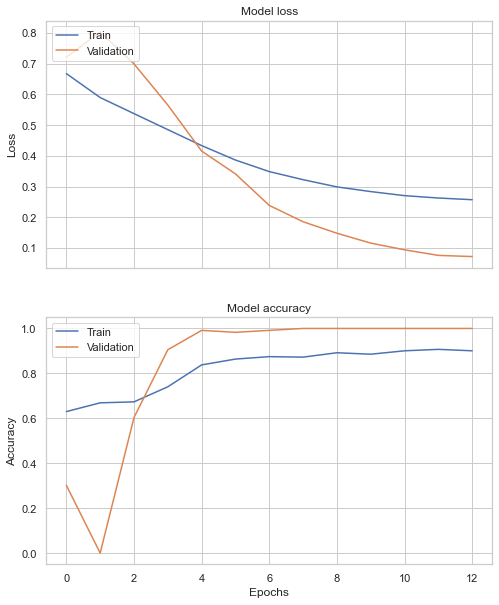

In [78]:
plot_history(hist)

### Pruebas

In [79]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0660 - accuracy: 1.0000


[0.06596671044826508, 1.0]

Como se puede apreciar, el modelo ha predicho correctamente todas las muestras del conjunto de prueba, y tiene una alta precisión para el conjunto de entrenamiento y validación. Es lógico pensar, por tanto, que hay factores clave que determinan la pertenencia a la mitad superior del ranking.

In [80]:
weights, bias = model.layers[0].weights
means = np.mean(weights.numpy(), axis=1)

In [82]:
means

array([ 0.05676974,  0.01324732,  0.06021781,  0.07326825,  0.09271809,
        0.02114756,  0.02204067,  0.02438771,  0.0201807 , -0.01976536,
        0.05127288,  0.00955212,  0.04107029,  0.00699119,  0.01038804,
       -0.03318137, -0.02280197], dtype=float32)

Los dos valores que más influencia tienen son:

In [81]:
print(train.drop(columns='world_rank').columns[np.argmax(means)])
print(train.drop(columns='world_rank').columns[np.argmin(means)])

income
broad_impact


No sorprende que la financiación afecte al rango global de la universidad. Aparentemente, el impacto de la universidad también afecta en gran medida.